# Projekat iz mašinskog učenja 1 (procena cena kuća)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('src')

from src.data_loader import load_data, explore_data, create_correlation_plot, select_features_by_correlation
from src.preprocessor import preprocess_data, split_data, scale_data
from src.pca_analyzer import apply_pca
from src.model_trainer import train_models, plot_cv_results
from src.evaluator import evaluate_final_models, display_results_table, plot_final_results
from src.analyzer import analyze_predictions

plt.style.use('default')
sns.set_palette("husl")

## 1. Učitavanje podataka

In [2]:
data = load_data("dataset/kc_house_data.csv")

Uspešno učitani podaci iz dataset/kc_house_data.csv
Oblik dataseta: (21613, 21)
['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


## 2. Eksplorativna analiza podataka


Tipovi podataka:
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Osnovne statistike za cenu:
count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

Nedostajuće vrednosti:
Nema nedostajućih vrednosti!


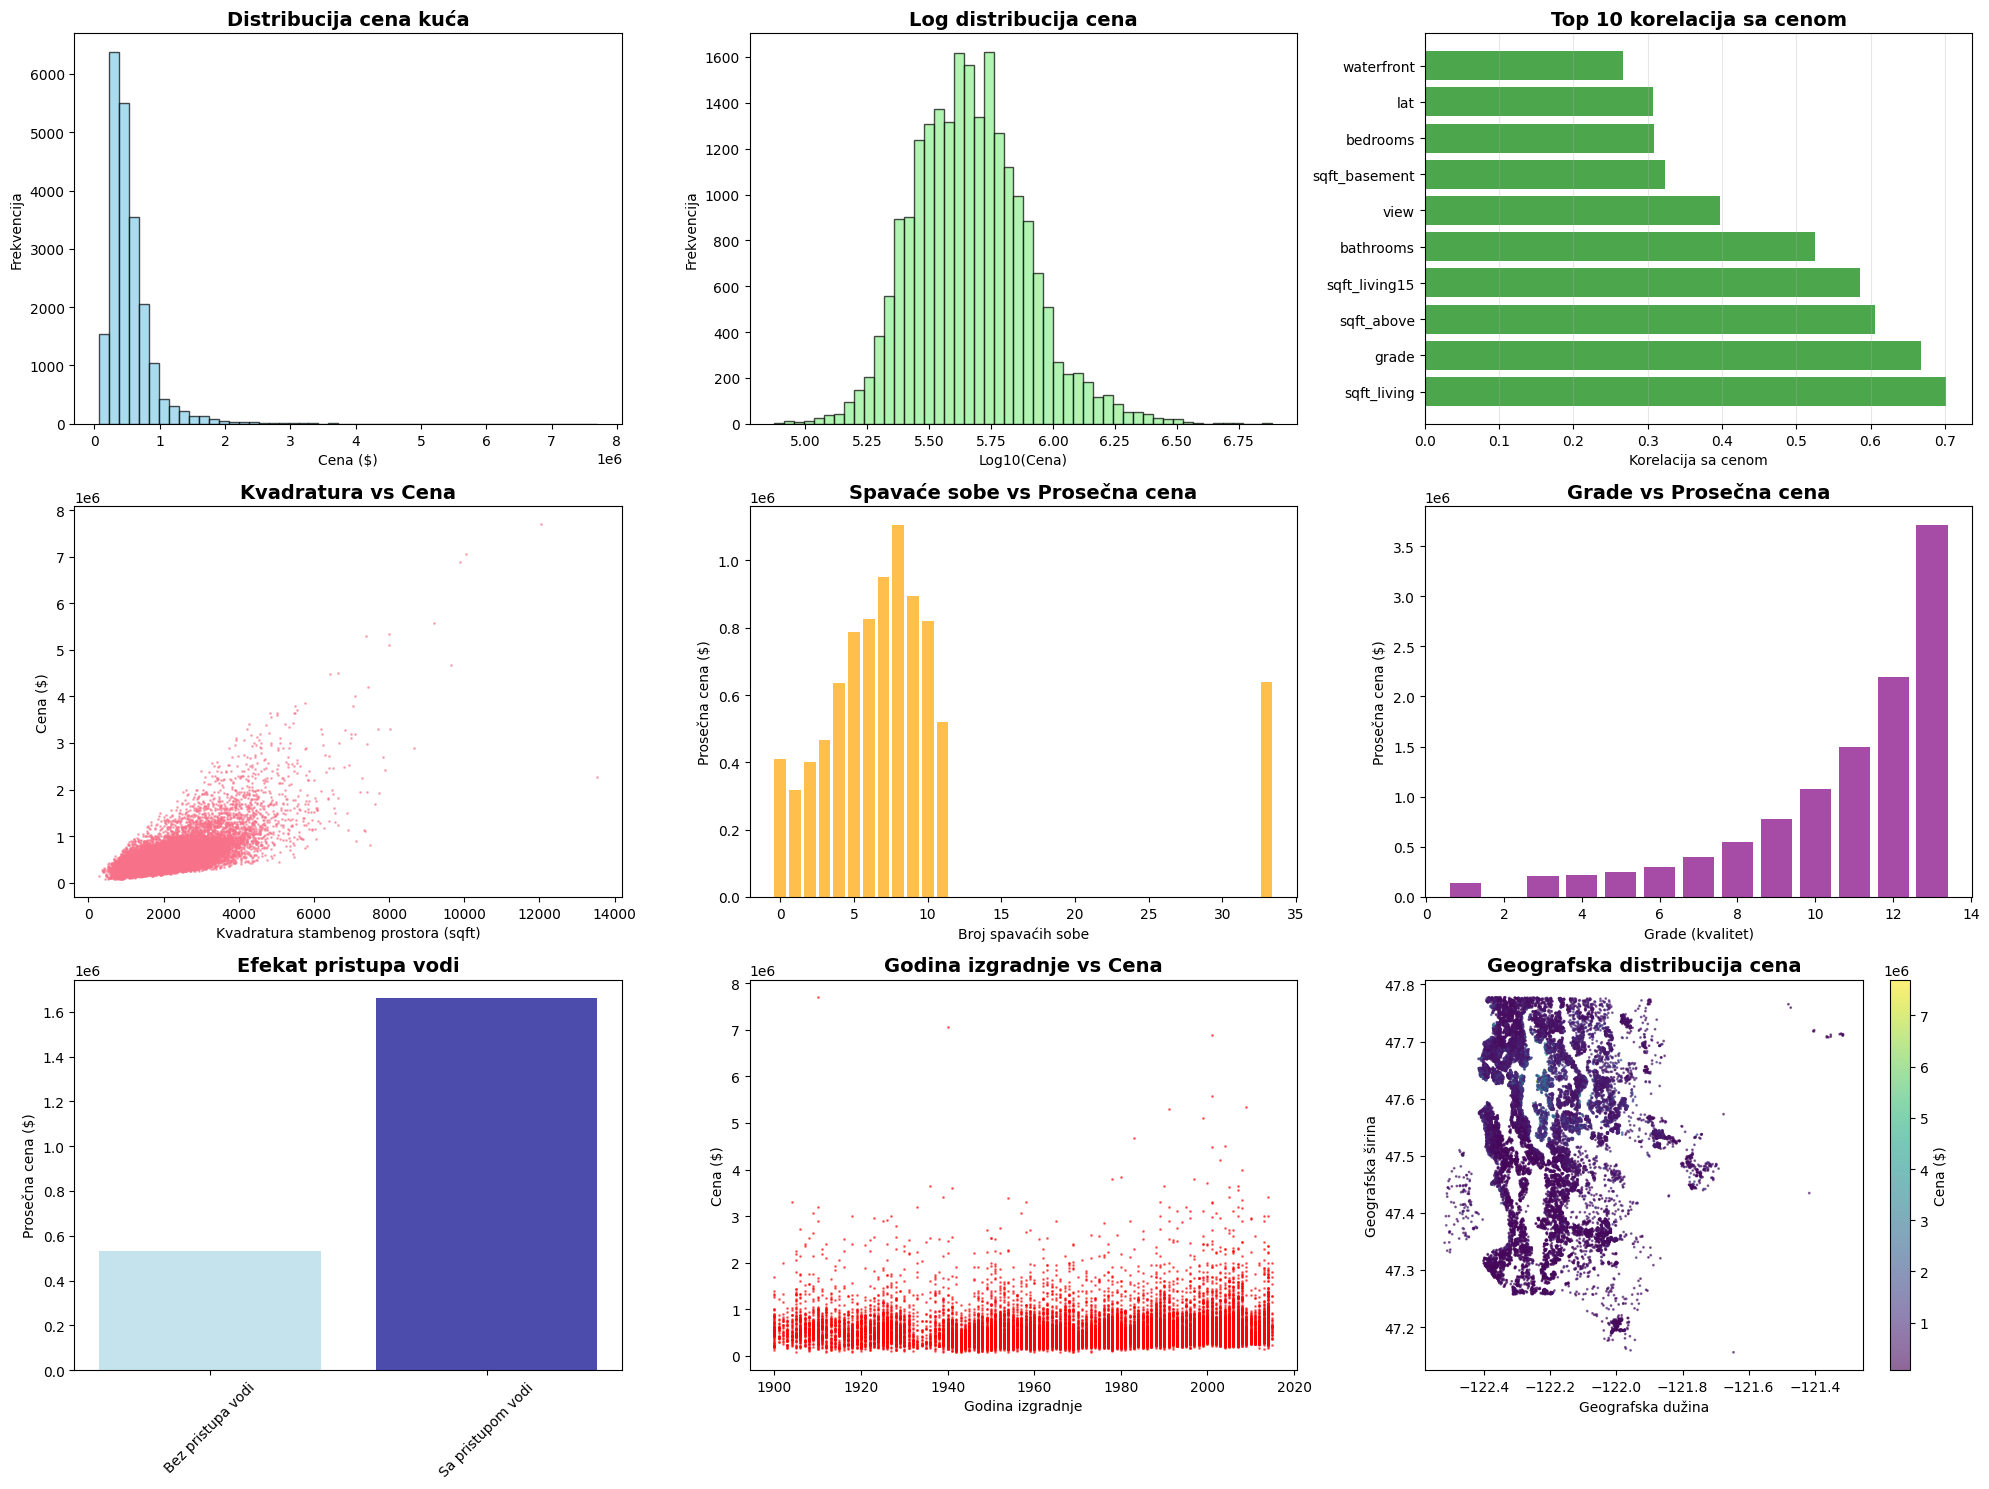


CENOVNE STATISTIKE:
Najjeftinija kuća: $75,000.00
Najskuplja kuća: $7,700,000.00
Prosečna cena: $540,088.14
Medijana cene: $450,000.00

KARAKTERISTIKE KUĆA:
Prosečna kvadratura: 2080 sqft
Prosečan broj spavaćih soba: 3.4
Prosečan broj kupatila: 2.1
Kuće sa pristupom vodi: 0.8%


In [3]:
if data is not None:
    explore_data(data)

## 3. Priprema podataka

In [4]:
if data is not None:
    # Uklanjanje suvišnih kolona + feature engineering
    df_processed = preprocess_data(data)

Uklonjene kolone: ['id', 'date']
Kreirano 5 novih feature-a: ['house_age', 'is_renovated', 'basement_ratio', 'is_large_house', 'luxury_score']


## 4. Korelaciona matrica

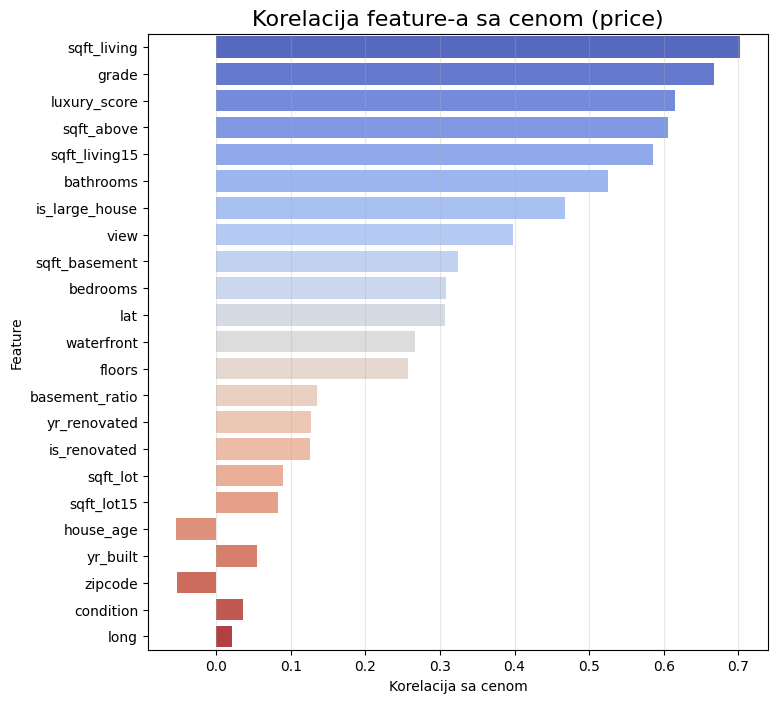

In [5]:
if df_processed is not None:
    price_corr = create_correlation_plot(df_processed)

## 5. Selekcija feature-a na osnovu korelacije

In [6]:
CORELATION_LIMIT = 0.1

if df_processed is not None:
    selected_df = select_features_by_correlation(df_processed, CORELATION_LIMIT)
    display(selected_df.head())

Feature-i sa |korelacijom| >= 0.1: 
['sqft_living', 'grade', 'luxury_score', 'sqft_above', 'sqft_living15', 'bathrooms', 'is_large_house', 'view', 'sqft_basement', 'bedrooms', 'lat', 'waterfront', 'floors', 'basement_ratio', 'yr_renovated', 'is_renovated']

Izbačene kolone: 
['sqft_lot', 'condition', 'yr_built', 'zipcode', 'long', 'sqft_lot15', 'house_age']

Oblik novog dataframe-a za učenje: (21613, 17)


,sqft_living,grade,luxury_score,sqft_above,sqft_living15,bathrooms,is_large_house,view,sqft_basement,bedrooms,lat,waterfront,floors,basement_ratio,yr_renovated,is_renovated,price
0,1180,7,0,1180,1340,1.00,0,0,0,3,47.5112,0,1.0,0.000000,0,0,221900.0
1,2570,7,0,2170,1690,2.25,1,0,400,3,47.7210,0,2.0,0.155642,1991,1,538000.0
2,770,6,0,770,2720,1.00,0,0,0,2,47.7379,0,1.0,0.000000,0,0,180000.0
3,1960,7,0,1050,1360,3.00,0,0,910,4,47.5208,0,1.0,0.464286,0,0,604000.0
4,1680,8,0,1680,1800,2.00,0,0,0,3,47.6168,0,1.0,0.000000,0,0,510000.0


## 6. Podela podataka na Train/Test i njihovo skaliranje

In [7]:
# FOR QUICK TESTING ONLY (CAP at 500)
# X = selected_df.drop('price', axis=1).iloc[:500]
# y = selected_df['price'].iloc[:500]  # target

X = selected_df.drop('price', axis=1)
y = selected_df['price'] # target

# Podela na train/test (85%/15%)
X_train, X_test, y_train, y_test = split_data(X, y)

# Skaliranje podataka
X_train_scaled, X_test_scaled, scaler = scale_data(X_train, X_test)


PODELA PODATAKA:
Train set: 18371 uzoraka (85.0%)
Test set: 3242 uzoraka (15.0%)

Skalirani su podaci


## 7. PCA analiza

Originalan broj feature-a: 16
Broj komponenti nakon PCA: 10
Objašnjena varijansa: 0.956 (95.6%)


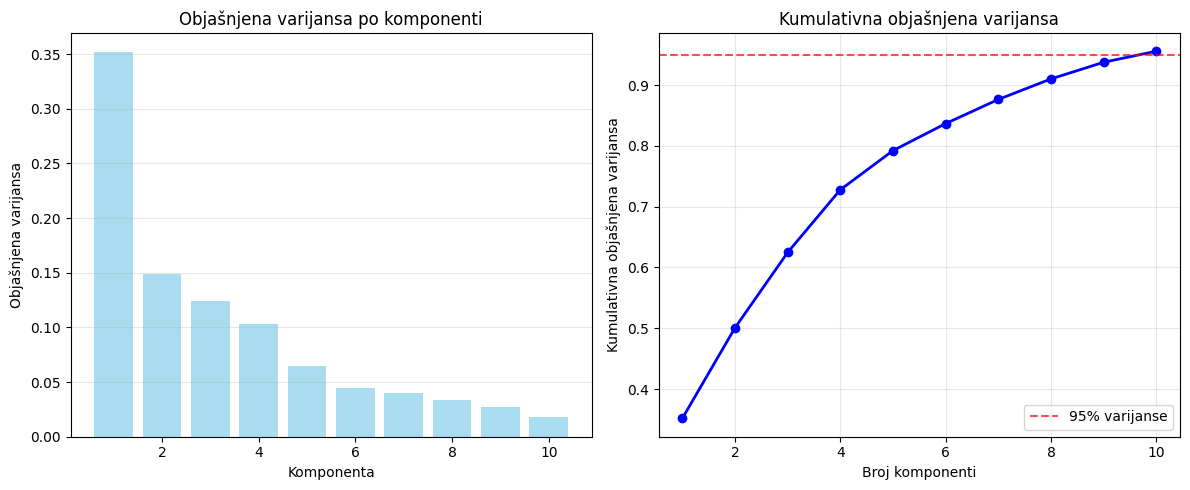


NAJVAŽNIJI FEATURE-I ZA PRVE 3 KOMPONENTE:

Komponenta 1:
  1. sqft_living: 0.400
  2. sqft_above: 0.365
  3. grade: 0.358
  4. bathrooms: 0.344
  5. sqft_living15: 0.343

Komponenta 2:
  1. basement_ratio: 0.550
  2. sqft_basement: 0.528
  3. floors: -0.344
  4. yr_renovated: 0.265
  5. is_renovated: 0.264

Komponenta 3:
  1. is_renovated: 0.604
  2. yr_renovated: 0.604
  3. basement_ratio: -0.287
  4. sqft_basement: -0.264
  5. waterfront: 0.183

PCA TRANSFORMACIJA:
Originalno: 16 feature-a
Nakon PCA: 10 komponenti


In [8]:
if selected_df is not None:
    X_train_pca, X_test_pca, pca = apply_pca(X_train_scaled, X_test_scaled, X_train) # X_train služi za prikaz originalnih kolona

    print(f"\nPCA TRANSFORMACIJA:")
    print(f"Originalno: {X_train_scaled.shape[1]} feature-a")
    print(f"Nakon PCA: {X_train_pca.shape[1]} komponenti")

## 8. Treniranje modela

In [9]:
if selected_df is not None:
    results = train_models(X_train_scaled, X_train_pca, y_train)
    
    print(f"\nMODELI TRENIRANI NA:")
    print(f"Originalni (skalirani) feature-i: {X_train_scaled.shape[1]} feature-a")
    print(f"PCA komponente: {X_train_pca.shape[1]} komponenti")
    print(f"Ukupno uzoraka za treniranje: {X_train_scaled.shape[0]}")


Treniranje Linear Regression...
Cross-validation evaluacija...
Linear Regression - Završeno!
CV MSE (Original): 41,884,922,560 ± 5,723,559,343
CV MSE (PCA): 44,643,688,545 ± 7,470,353,373
CV R² (Original): 0.682 ± 0.018
CV R² (PCA): 0.662 ± 0.026

Treniranje Random Forest...
Pretraga hiperparametara (originalni prostor)...
Pretraga hiperparametara (PCA prostor)...
Cross-validation evaluacija...
Random Forest - Završeno!
CV MSE (Original): 25,938,049,813 ± 6,157,885,736
CV MSE (PCA): 28,735,875,005 ± 4,838,183,356
CV R² (Original): 0.805 ± 0.028
CV R² (PCA): 0.783 ± 0.017

Treniranje SVR...
Pretraga hiperparametara (originalni prostor)...
Pretraga hiperparametara (PCA prostor)...
Cross-validation evaluacija...
SVR - Završeno!
CV MSE (Original): 135,683,511,749 ± 14,575,341,012
CV MSE (PCA): 135,491,534,541 ± 14,566,574,671
CV R² (Original): -0.031 ± 0.006
CV R² (PCA): -0.030 ± 0.006

Treniranje KNN...
Pretraga hiperparametara (originalni prostor)...
Pretraga hiperparametara (PCA prosto

## 9. Vizualizacija

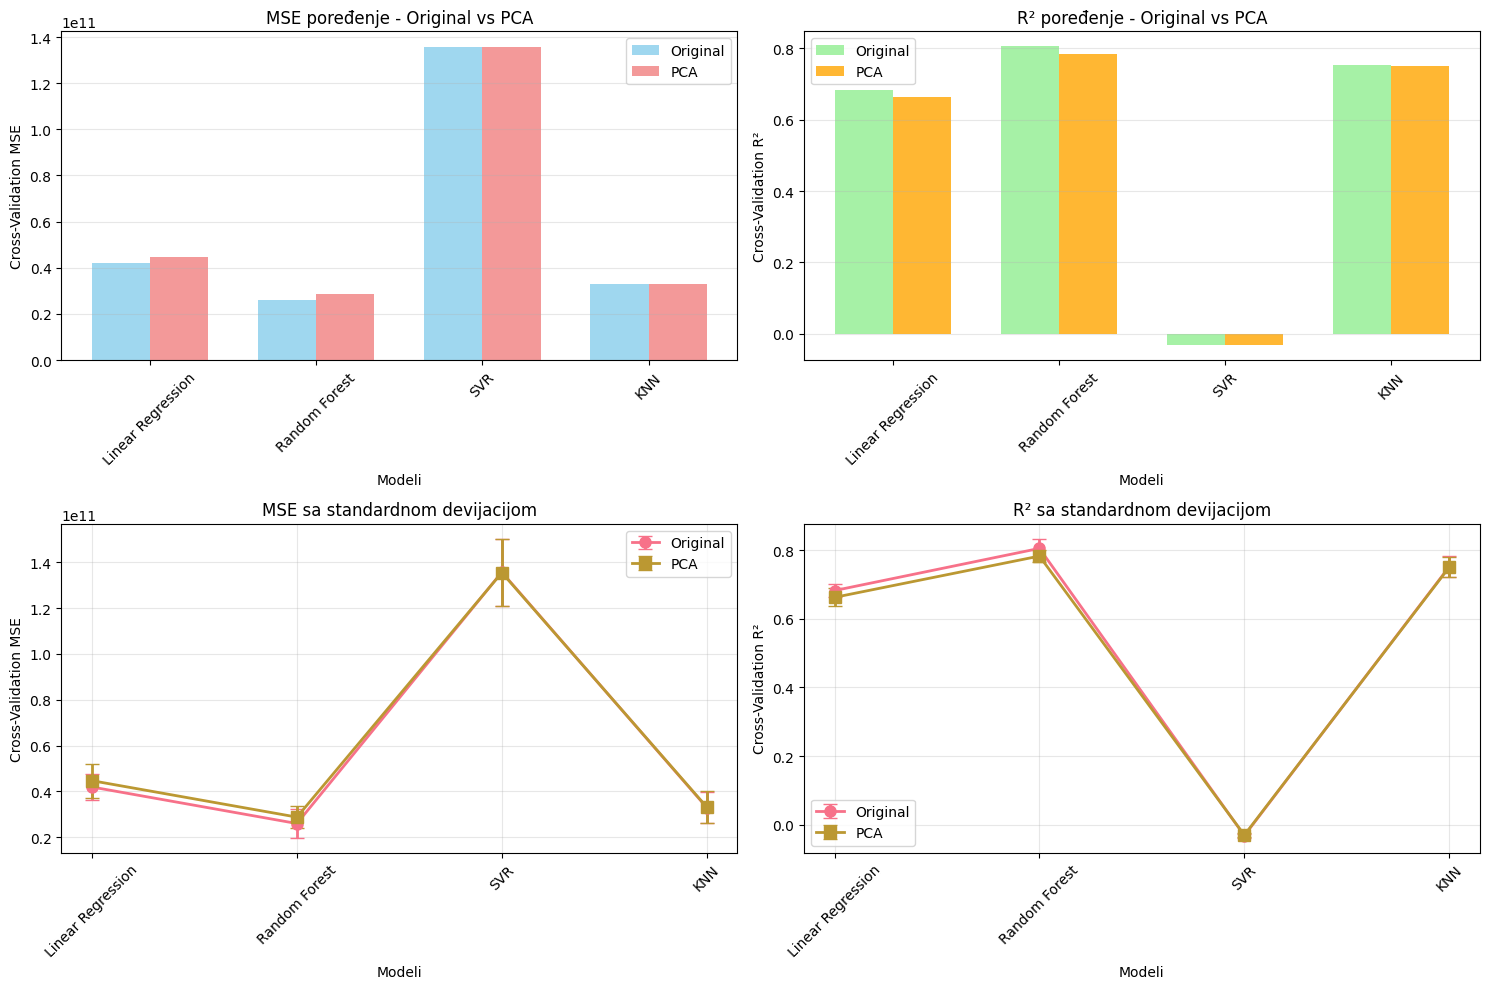

In [10]:
if selected_df is not None:
    plot_cv_results(results)

## 10. Evaluacija na test skupu

In [11]:
if selected_df is not None:
    final_results = evaluate_final_models(results, X_test_scaled, X_test_pca, y_test)
    
    print(f"\nFINALNA EVALUACIJA:")
    print(f"Test skup: {X_test_scaled.shape[0]} uzoraka")
    print(f"Feature-i (originalni): {X_test_scaled.shape[1]} skaliranih feature-a")
    print(f"Target: cene nekretnina")


Evaluacija Linear Regression...
  Najbolji prostor: Original
  Test MAE: $133,114
  Test MSE: 50,102,643,819
  Test RMSE: $223,836
  Test R²: 0.672
  Predikcije u ±10%: 28.0%
  Predikcije u ±20%: 51.8%

Evaluacija Random Forest...
  Najbolji prostor: Original
  Test MAE: $88,817
  Test MSE: 26,922,869,624
  Test RMSE: $164,082
  Test R²: 0.824
  Predikcije u ±10%: 46.4%
  Predikcije u ±20%: 73.3%

Evaluacija SVR...
  Najbolji prostor: PCA
  Test MAE: $224,457
  Test MSE: 157,554,006,639
  Test RMSE: $396,931
  Test R²: -0.032
  Predikcije u ±10%: 15.3%
  Predikcije u ±20%: 30.2%

Evaluacija KNN...
  Najbolji prostor: Original
  Test MAE: $102,642
  Test MSE: 39,026,950,555
  Test RMSE: $197,552
  Test R²: 0.744
  Predikcije u ±10%: 41.7%
  Predikcije u ±20%: 68.1%

FINALNA EVALUACIJA:
Test skup: 3242 uzoraka
Feature-i (originalni): 16 skaliranih feature-a
Target: cene nekretnina


## 11. Upoređivanje rezultata i odabir najboljeg


TABELA SVIH REZULTATA
Model           Prostor  CV R²    Test R²  RMSE         MAE          ±10%   ±20%  
--------------------------------------------------------------------------------
Random Forest   Original 0.805    0.824    $164,082     $88,817      46.4 % 73.3 %
KNN             Original 0.752    0.744    $197,552     $102,642     41.7 % 68.1 %
Linear Regression Original 0.682    0.672    $223,836     $133,114     28.0 % 51.8 %
SVR             PCA      -0.030   -0.032   $396,931     $224,457     15.3 % 30.2 %
--------------------------------------------------------------------------------
NAJBOLJI MODEL: Random Forest (Original prostor)
Test R²: 0.824
RMSE: $164,082


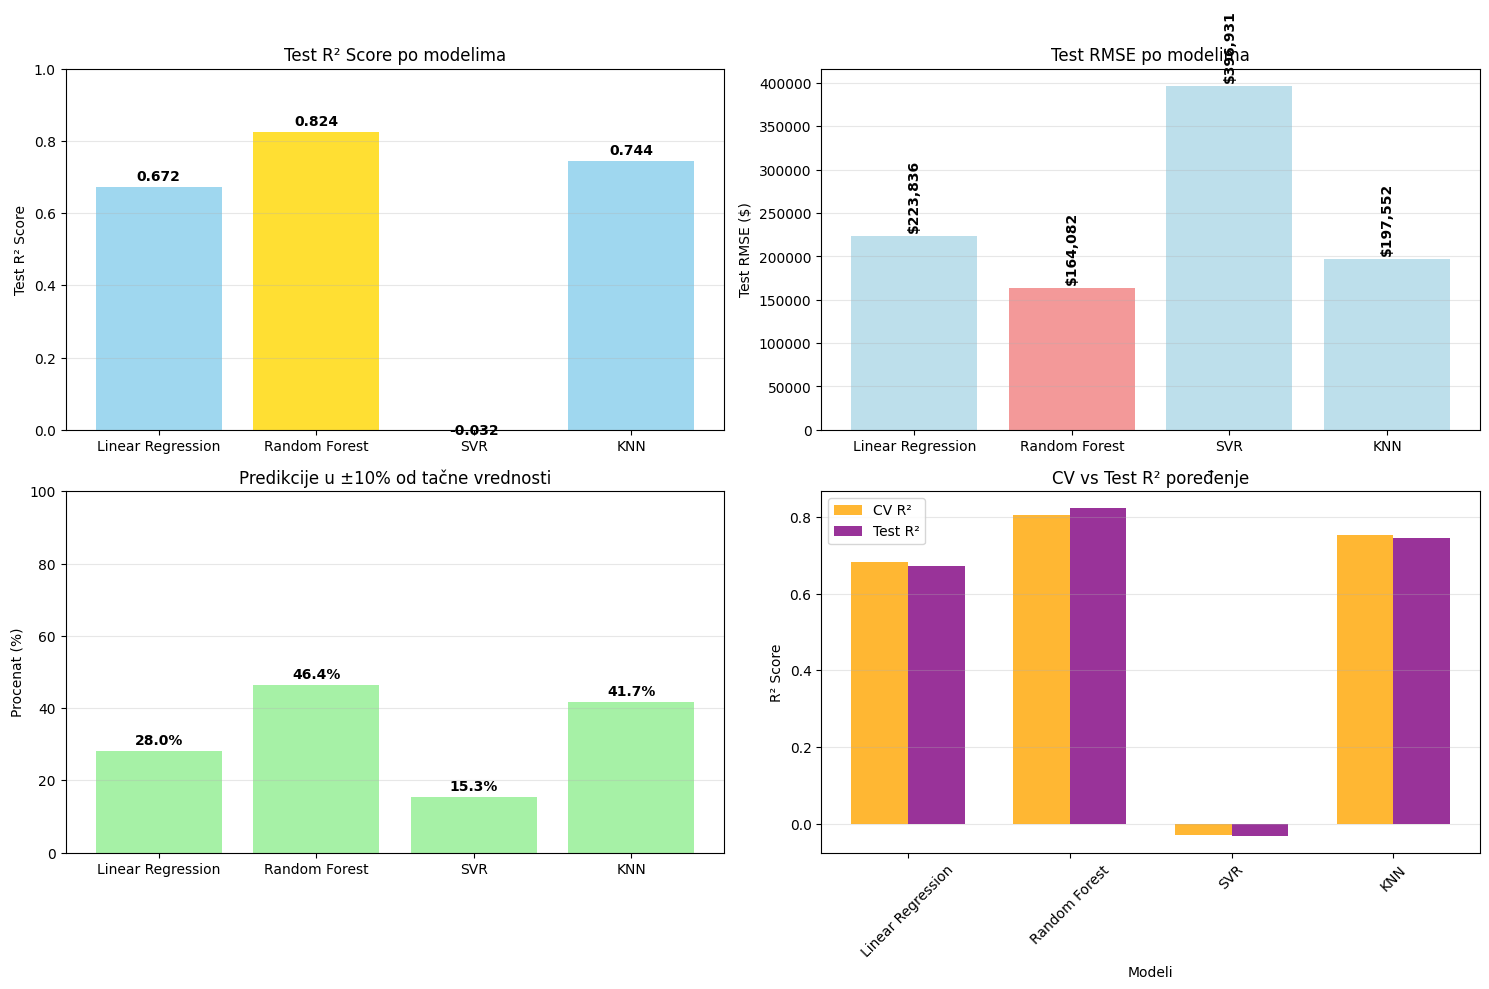

In [12]:
if selected_df is not None:
    display_results_table(final_results)
    plot_final_results(final_results)

## 12. Analiza najboljeg modela


NAJBOLJI MODEL: Random Forest
Test R²: 0.824
Test RMSE: $164,082
Prostor: Original
Treniran na 16 originalnih feature-a ili 10 PCA komponenti (prema izboru)


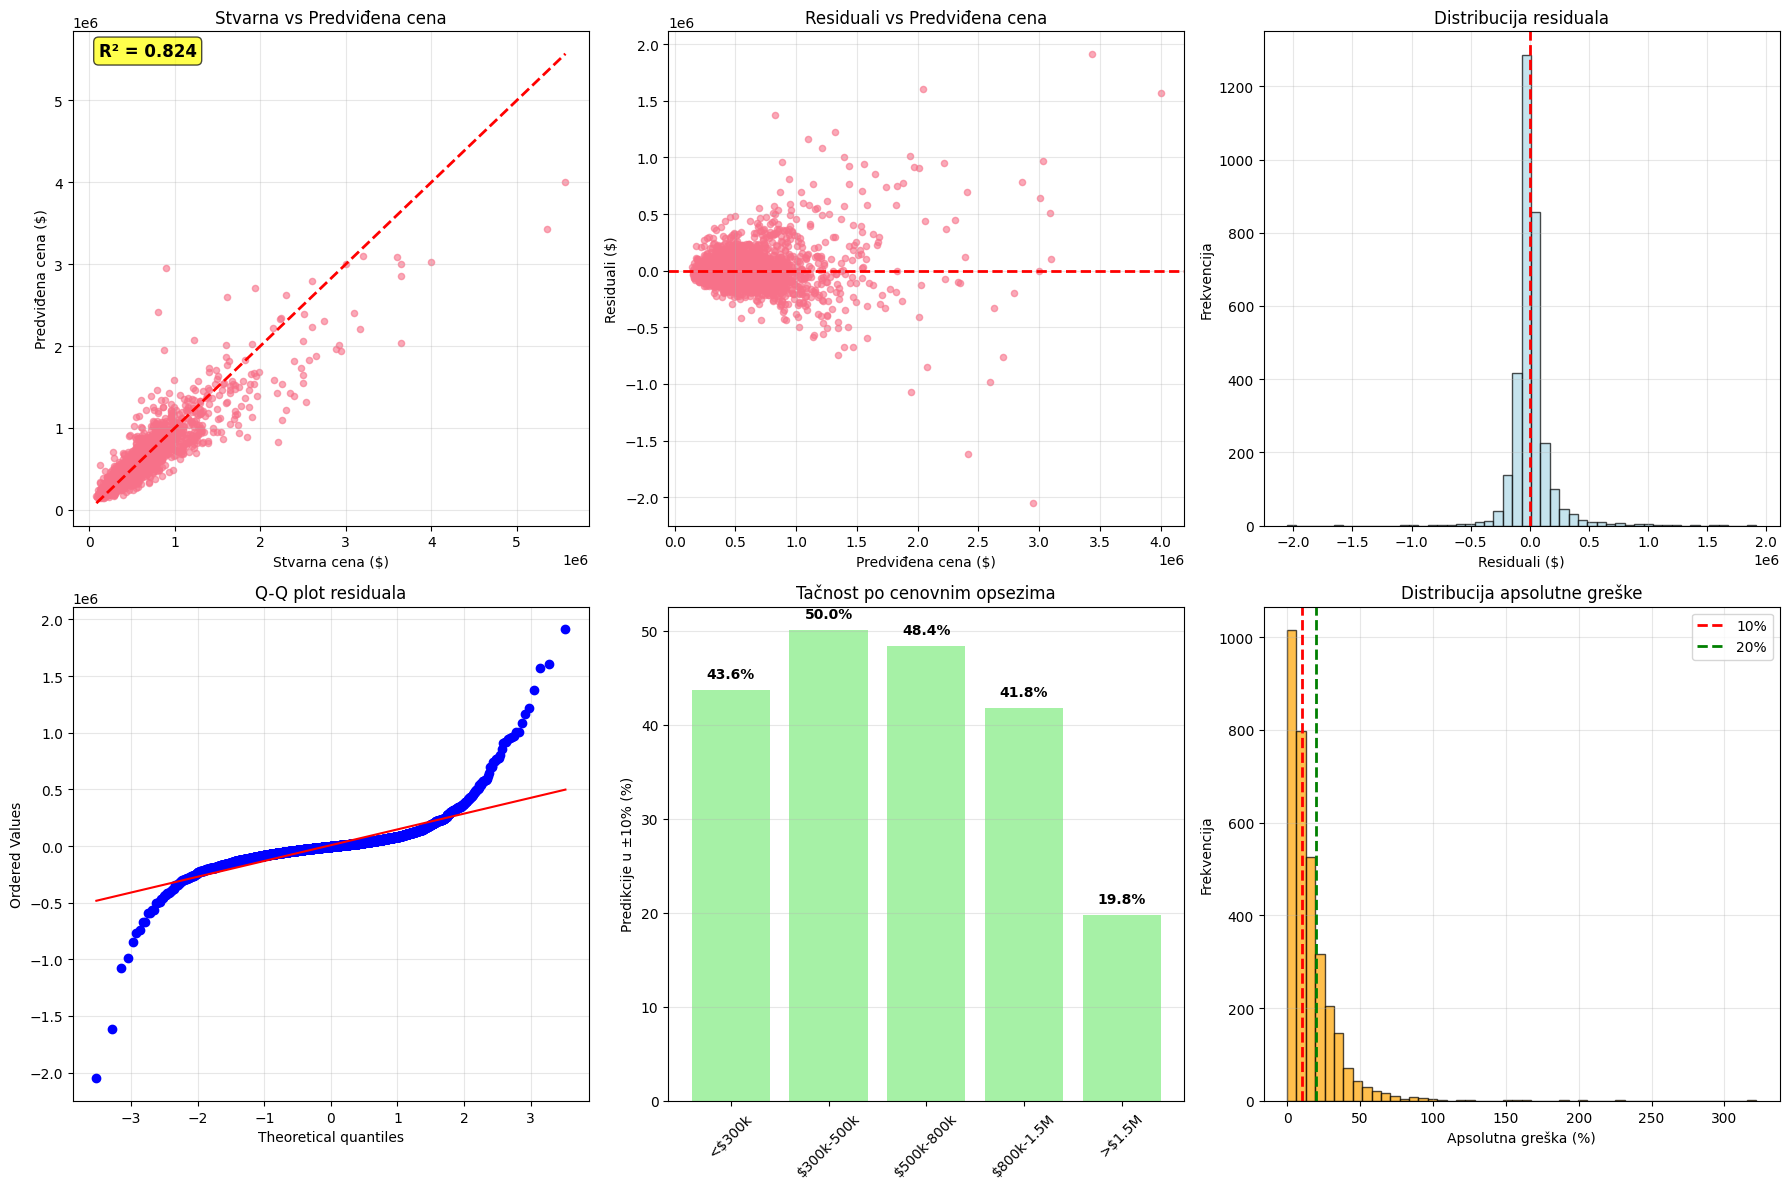


STATISTIKE GREŠAKA:
Srednja apsolutna greška: $88,817
Medijana apsolutne greške: $50,152
Standardna devijacija residuala: $163,915
Maksimalna pozitivna greška: $1,913,982
Maksimalna negativna greška: $-2,051,818

PROCENAT TAČNIH PREDIKCIJA:
U ±5%: 25.2%
U ±10%: 46.4%
U ±15%: 62.7%
U ±20%: 73.3%
U ±25%: 81.4%

5 NAJGORIH PREDIKCIJA:
Stvarna      Predviđena   Greška     Greška %  
--------------------------------------------------
$130,000     $548,254     $418,254   321.7    %
$900,000     $2,951,818   $2,051,818 228.0    %
$800,000     $2,417,022   $1,617,022 202.1    %
$119,500     $342,924     $223,424   187.0    %
$180,000     $470,170     $290,170   161.2    %

INFORMACIJE O FEATURE-IMA:
• Korelacijski limit: 0.1
• Broj originalnih feature-a nakon pripreme: 16
• Broj PCA komponenti: 10


In [13]:
if selected_df is not None:
    best_model_name = max(final_results.keys(), key=lambda x: final_results[x]['test_r2'])
    best_result = final_results[best_model_name]
    
    print(f"\nNAJBOLJI MODEL: {best_model_name}")
    print(f"Test R²: {best_result['test_r2']:.3f}")
    print(f"Test RMSE: ${best_result['test_rmse']:,.0f}")
    print(f"Prostor: {best_result['space_type']}")
    print(f"Treniran na {X_train_scaled.shape[1]} originalnih feature-a ili {X_train_pca.shape[1]} PCA komponenti (prema izboru)")
    
    analyze_predictions(best_result, best_model_name, y_test)
    
    print(f"\nINFORMACIJE O FEATURE-IMA:")
    print(f"• Korelacijski limit: {CORELATION_LIMIT}")
    print(f"• Broj originalnih feature-a nakon pripreme: {X_train.shape[1]}")
    print(f"• Broj PCA komponenti: {X_train_pca.shape[1]}")